<a href="https://colab.research.google.com/github/crux82/BISS-2024/blob/main/BISS-2024_LAB-2.2_ExtremITA_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### BISS-2024 Tutorial

# LAB 2.2: Large Language Models and How to Instruction Tune Them (in a Sustainable Way)

**Authors**: C.D. Hromei & D. Croce

This is an implementation for training and using a Large Language Model (based on [LLaMA](https://ai.meta.com/blog/large-language-model-llama-meta-ai/)) with instructions in order to solve the linguistic tasks of [EVALITA](https://www.evalita.it/campaigns/evalita-2023/). In this lab, we will see how to encode datasets from any format to a sequence to sequence format, train the model using [Q-LoRA](https://arxiv.org/abs/2305.14314), perform the inference using the previous trained model for generating answers to instructions, and finally, how to encode back the data to the original format.. all of it using the only available *T4 GPU with 15GB from Google Colab*.

The tutorial is split into 4 steps, reflecting the aforementioned process:
- Step 1 - Encoding the data
- **Step 2 - Training the LLaMA model**
- Step 3 - Inference: generating answers
- Step 4 - Deconding the data

# Index:
1. Introduction, Workflow and Objectives
2. Preliminary steps
3. Setting of the Hyperparameters
4. Utils functions
5. Loading the data from previous step
6. Training and saving the model
7. Uploading the model to HuggingFace

## Step 2 - Training the LLaMA model

In this Notebook we will see how to train our state-of-the-art solution for EVALITA. The model is based on the Foundational LLaMA models, exploiting the smallest available one, i.e. with 7 billion parameters.  
As the task is in Italian, we will employ an Italian Instruction-Tuned LLaMA: [Camoscio](https://huggingface.co/sag-uniroma2/extremITA-Camoscio-7b). Moreover, we have limited resources (15GB of GPU memory), so we will use some techniques for tuning only a subset of the parameters with [Q-LoRA](https://arxiv.org/abs/2305.14314) and [parameters quantization](https://huggingface.co/blog/4bit-transformers-bitsandbytes).


## Input
The input of the Notebook is the data we generated previously, in the 4-columns format, in order to train the model.

## Output
The "output" will be the trained LLaMA model: we will save it on Google Colab and (optional) upload it to the HuggingFace Hub.

## Preliminary Steps:

1.   Runtime SetUp
2.   Install Packages

### RunTime SetUp

Please make sure you are using the runtime environment according to the following settings:
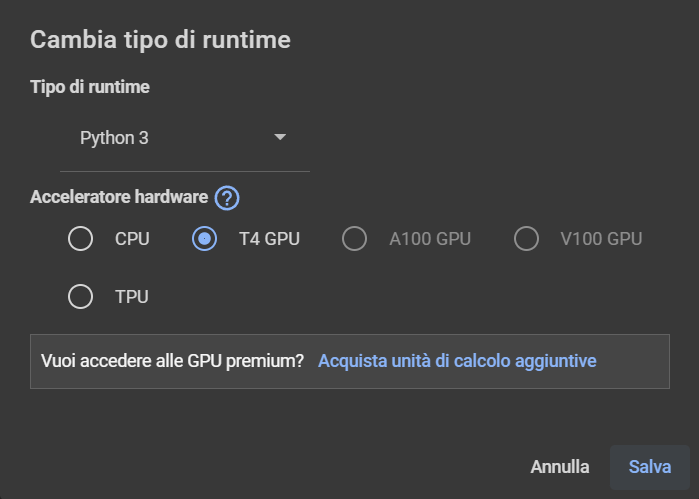

## Install packages

Tip: An initial "!" allows you to execute the rest if the code in the line as on the OS shell

In [1]:
# install eventually required packages

! pip install peft
! pip install sentencepiece
! pip install accelerate
! pip install bitsandbytes
! pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import transformers
from transformers import LlamaTokenizer, LlamaForCausalLM
import csv
import json

from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)

import torch
from datasets import load_dataset
import pandas as pd


#### Download data
We download 100 examples for each task from EVALITA 2023, already "encoded" for the fine-tuning

In [4]:
# 100 examples for the training process
! wget -nc https://raw.githubusercontent.com/crux82/CLiC-it_2023_tutorial/main/data/train_100.txt

# 100 examples for the validation process
! wget -nc https://raw.githubusercontent.com/crux82/CLiC-it_2023_tutorial/main/data/dev_100.txt


--2025-06-04 11:59:58--  https://raw.githubusercontent.com/crux82/CLiC-it_2023_tutorial/main/data/train_100.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 728283 (711K) [text/plain]
Saving to: ‘train_100.txt’

train_100.txt       100%[===================>] 711.21K  --.-KB/s    in 0.01s   

2025-06-04 12:00:00 (58.0 MB/s) - ‘train_100.txt’ saved [728283/728283]

--2025-06-04 12:00:00--  https://raw.githubusercontent.com/crux82/CLiC-it_2023_tutorial/main/data/dev_100.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 665538 (6

#### Utils code for generating text in the ad hoc form for each task

In [5]:
def target_answer_to_text(target_text: str, task: str):
    if task == "acti_a":
        if target_text == "sì" or target_text == "si":
            return "cospirazione"
        else:
            return "non_cospirazione"
    elif task == "acti_b":
        return target_text
    elif task == "clinkart":
        return target_text
    elif task == "discotex_1":
        if target_text == "sì" or target_text == "si":
            return "coerente"
        else:
            return "non_coerente"
    elif task == "discotex_2":
        return target_text
    elif task == "emit_a":
        return target_text
    elif task == "emit_b":
        return target_text
    elif task == "emotivita":
        return target_text
    elif task == "geolingit":
        return target_text
    elif task == "haspeede":
        if target_text == "sì" or target_text == "si":
            return "odio"
        else:
            return "non_odio"
    elif task == "hodi_a":
        if target_text == "sì" or target_text == "si":
            return "omotransfobico"
        else:
            return "non_omotransfobico"
    elif task == "hodi_b":
        return target_text
    elif task == "langlearn":
        if target_text == "sì" or target_text == "si":
            return "corretto"
        else:
            return "incorretto"
    elif task == "multifakedetective":
        return target_text
    elif task == "nermud":
        return target_text
    elif task == "politicit":
        return target_text
    elif task == "wicita":
        if target_text == "sì" or target_text == "si":
            return "uguale"
        else:
            return "differente"
    else:
        return "task sconosciuto"

def target_text_to_answer(target_text: str, task: str):
    if task == "acti_a":
        if target_text == "cospirazione":
            return "sì"
        else:
            return "no"
    elif task == "acti_b":
        return target_text
    elif task == "clinkart":
        return target_text
    elif task == "discotex_1":
        if target_text == "coerente":
            return "sì"
        else:
            return "no"
    elif task == "discotex_2":
        return target_text
    elif task == "emit_a":
        return target_text
    elif task == "emit_b":
        return target_text
    elif task == "emotivita":
        return target_text
    elif task == "geolingit":
        return target_text
    elif task == "haspeede":
        if target_text == "odio":
            return "sì"
        else:
            return "no"
    elif task == "hodi_a":
        if target_text == "omotransfobico":
            return "sì"
        else:
            return "no"
    elif task == "hodi_b":
        return target_text
    elif task == "langlearn":
        if target_text == "corretto":
            return "sì"
        else:
            return "no"
    elif task == "multifakedetective":
        return target_text
    elif task == "nermud":
        return target_text
    elif task == "politicit":
        return target_text
    elif task == "wicita":
        if target_text == "uguale":
            return "sì"
        else:
            return "no"
    else:
        return "task sconosciuto"

def task_to_prompt(task: str):
    if task == "acti_a":
        return "In questo testo si parla di una cospirazione? Rispondi sì o no."
    elif task == "acti_b":
        return "Di quale teoria cospirazionista parla questo testo, tra \"Covid\", \"Qanon\", \"Terrapiattista\", \"Russia\"?"
    elif task == "clinkart":
        return "Trova i risultati dei test e delle misurazioni nel testo. Per ogni risultato, scrivi \"[BREL]\", seguito dal risultato seguito da \"[SEP]\", seguito dal test, seguito da \"[EREL]\". Se non trovi nessun risultato, scrivi \"[NOREL]\"."
    elif task == "discotex_1":
        return "Le due frasi seguenti, separate da \"[SEP]\", sono coerenti tra loro? Rispondi sì o no."
    elif task == "discotex_2":
        return "Quanto è coerente questa frase, su una scala da 0 a 5?"
    elif task == "emit_a":
        return "Quali emozioni sono espresse in questo testo? Puoi scegliere una o più emozioni tra \"rabbia\", \"anticipazione\", \"disgusto\", \"paura\", \"gioia\", \"amore\", \"tristezza\", \"sorpresa\", \"fiducia\", o \"neutro\"."
    elif task == "emit_b":
        return "Di cosa parla il testo, tra \"direzione\", \"argomento\", \"entrambi\", \"non specificato\"?"
    elif task == "emotivita":
        return "Scrivi quanta valenza è espressa in questo testo su una scala da 1 a 5, seguito da quanto stimolo è espresso in questo testo su una scala da 1 a 5, seguito da quanto controllo è espresso in questo testo su una scala da 1 a 5."
    elif task == "geolingit":
        return "Scrivi la regione di appartenenza di chi ha scritto questo testo, seguito dalla latitudine, seguita dalla longitudine."
    elif task == "haspeede":
        return "In questo testo si esprime odio? Rispondi sì o no."
    elif task == "hodi_a":
        return "In questo testo si esprime odio omotransfobico? Rispondi sì o no."
    elif task == "hodi_b":
        return "Con quali parole l'autore del testo seguente esprime odio omotransfobico? Separa le sequenze di parole con [gap]."
    elif task == "langlearn":
        return "Questi due testi separati da [SEP] sono presentati nell'ordine in cui sono stati scritti? Rispondi sì o no."
    elif task == "multifakedetective":
        return "L'evento riportato nel testo è \"certamente vero\", \"probabilmente vero\", \"probabilmente falso\", o \"certamente falso\"?"
    elif task == "nermud":
        return "Scrivi le menzioni di entità nel testo, indicandone il tipo: [PER] (persona), [LOC] (luogo), [ORG] (organizzazione)."
    elif task == "politicit":
        return "Scrivi se l'autore del testo è \"uomo\" o \"donna\", seguito dalla sua appartenenza politica tra \"destra\", \"sinistra\", \"centrodestra\", \"centrosinistra\"."
    elif task == "wicita":
        return "La parola compresa tra [TGTS] e [TGTE] ha lo stesso significato in entrambe le frasi? Rispondi sì o no."
    else:
        return "task sconosciuto"


 ################ GENERATE METHODS ################
def generate_prompt_pred(instruction, input_):
    return f"""Di seguito è riportata un'istruzione che descrive un task, insieme ad un input che fornisce un contesto più ampio. Scrivete una risposta che completi adeguatamente la richiesta.
### Istruzione:
{instruction}
### Input:
{input_}
### Risposta:"""

def generate_prompt_str(instruction, input_):
    return f"""Di seguito è riportata un'istruzione che descrive un task, insieme ad un input che fornisce un contesto più ampio. Scrivete una risposta che completi adeguatamente la richiesta.
### Istruzione:
{instruction}
### Input:
{input_}
### Risposta:"""

def generate_prompt(data_point):
    if data_point["input"]:
        return f"""Di seguito è riportata un'istruzione che descrive un task, insieme ad un input che fornisce un contesto più ampio. Scrivete una risposta che completi adeguatamente la richiesta.
### Istruzione:
{data_point["instruction"]}
### Input:
{data_point["input"]}
### Risposta:
{data_point["output"]}"""
    else:
        return f"""Di seguito è riportata un'istruzione che descrive un task. Scrivete una risposta che completi adeguatamente la richiesta.
### Istruzione:
{data_point["instruction"]}
### Risposta:
{data_point["output"]}"""

------------------------------
## Hyper-parameteres

Here we set all the hyper-parameters we need:
- specify the device to exploit the GPU (`cuda`)
- use the tokenizer for llama 7b
- take the base model of Camoscio from [Huggingface](https://huggingface.co/sag-uniroma2/extremITA-Camoscio-7b)
- the paths for our training and development set
- we cut off the length of sentences to maximum `512` words and `1200` charachters
- we set then the LoRA hyper-params:
  - the rank `R` of the two matrices A and B
  - the normalization factor `Alpha`
  - the `dropout rate`
  - the target modules, i.e. where to insert the LoRA modules: `q`, `k` and `v` for the attention and `o` for the final output layer.
- `number of epochs` to train the model
- `batch_size` is the global size of our batch of examples, but since we have a small GPU with only 15GB of memory, we need to scale this down, so we introduce 2 new concepts:
  - `micro_batch_size` is the real size of the batch we will use, which will be smaller (usually 2,4,8)
  - `gradient_accumulation_steps` how many steps (of batches) we want to accumulate the `loss` for before we update the parameters of the model. In this way we simulate a bigger `batch_size` by accumulating the `loss` for more than one iteration, and then we update the model.
- the `learning_rate`, which controls the intensity of the update
- the `warmup_ratio`, as we are using a scheduler for the learning rate, i.e. it will not be fixed during the whole training, but will vary based on the time.

Just to give an idea, usually you will set the learning rate to a fixed value and stick with it. That is the constant scheduler. There are different one, here after an image:

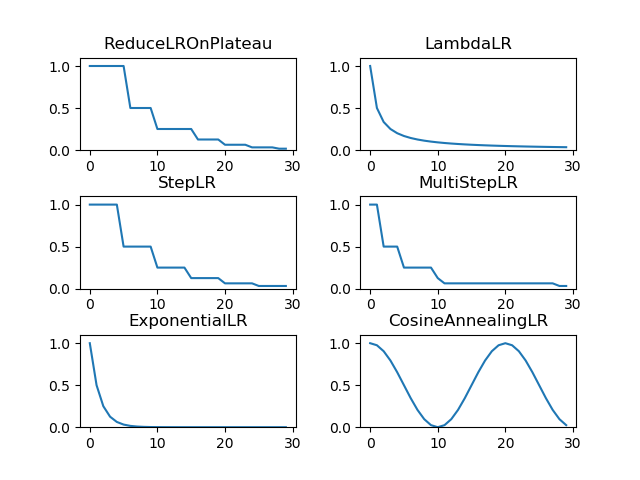

We will be using a linear decay scheduler with warmup of `0.1`, as in the figure below. This means it will linearly grow for `10%` of the training, and the linearly decay for the rest.

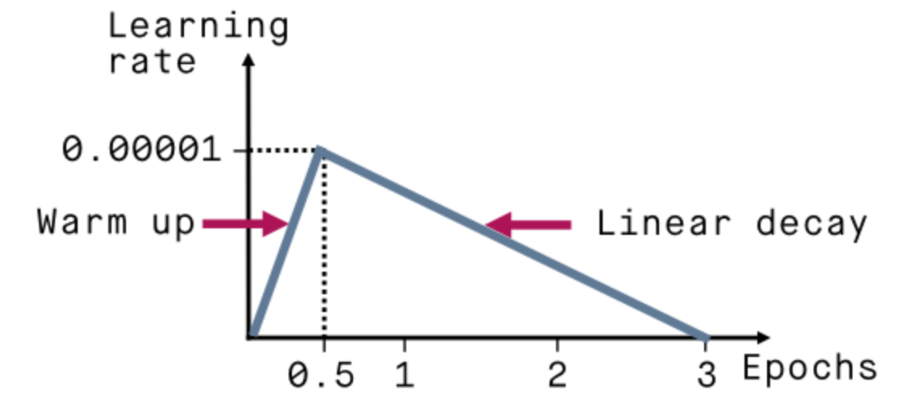

In [6]:
DEVICE = "cuda"
TOKENIZER_MODEL = "yahma/llama-7b-hf"
BASE_MODEL = "sag-uniroma2/extremITA-Camoscio-7b"

input_train_path = f"train_100.txt"
input_dev_path = f"dev_100.txt"
OUTPUT_DIR = f"extremITLLaMA"

CUTOFF_LEN = 512
CUT_INPUT_CHAR_LENGTH = 1200

task = "*"

LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT= 0.05
LORA_TARGET_MODULES = [
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
]

EPOCHS = 1 # better 2 epochs
BATCH_SIZE = 32 #it would be better 128 but it may require too much GPU memory
MICRO_BATCH_SIZE = 8 #it would be better 32 but it may require too much GPU memory
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
LEARNING_RATE = 3e-4
WARMUP_RATIO = 0.1

tmp_train_file_name = "tmp_train.json"
tmp_dev_file_name = "tmp_dev.json"


## Functions
We will define now some functions in order to facilitate the readability of the Notebook.

In [7]:
#============================================
#               FUNCTIONS
#============================================

#LOAD INPUT TSV files in the extremITA format
def load(input_file_path):
    dataset_df = pd.read_csv(input_file_path, header=None, usecols=[0,1, 2, 3], names=['0', '1', '2', '3'], \
                             sep="\t", quoting=csv.QUOTE_NONE, encoding='utf-8').astype(str)
    dataset_df = dataset_df.rename(
        columns={"0": "id", "1": "prefix", "2": "input_text", "3": "target_text"}
    )
    dataset_df = dataset_df[["id", "input_text", "target_text", "prefix"]]
    return dataset_df


# Notice: in the generate_and_tokenize_prompt function result["labels"] is rewritten
def tokenize(prompt, cutoff_len, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=cutoff_len,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < cutoff_len
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result

# Notice: result["labels"] is rewritten so that only the output is considered
def generate_and_tokenize_prompt(data_point, add_eos_token=True):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenize(full_prompt, CUTOFF_LEN)

    user_prompt = generate_prompt_str(
        data_point["instruction"], data_point["input"]
    )
    tokenized_user_prompt = tokenize(
        user_prompt, CUTOFF_LEN, add_eos_token=add_eos_token
    )
    user_prompt_len = len(tokenized_user_prompt["input_ids"])

    if add_eos_token:
        user_prompt_len -= 1

    tokenized_full_prompt["labels"] = [
        -100
    ] * user_prompt_len + tokenized_full_prompt["labels"][
        user_prompt_len:
    ]  # could be sped up, probably
    return tokenized_full_prompt



def load_and_prepare_data(input_file_path: str, tasks):

    df = load(input_file_path)

    if isinstance(tasks, str):
        if(tasks != "*"):
            df = df[df["prefix"]==tasks]
    elif isinstance(tasks, list):
        tmp = None
        for task in tasks:
            if tmp == None:
                tmp = df[df["prefix"]==task]
            else:
                tmp += df[df["prefix"]==task]
        df = tmp

    print(df.target_text.value_counts())

    dataset_data = [
        {
            "instruction": task_to_prompt(row_dict["prefix"]),
            "input": row_dict["input_text"],
            "output": target_text_to_answer(row_dict["target_text"], row_dict["prefix"])
        }
        for row_dict in df.to_dict(orient="records")
    ]

    return dataset_data

def trim_long_input(json_input, cutoff_len=10000000):
    for json_data in json_input:
        json_data["input"] = json_data["input"][:cutoff_len]
    return json_input


## Fine-tuning the LLM
We first load the data that was already prepared to contain maximum 100 examples for each task, then we cut the maximum length accordingly to the previous params.

In [8]:
#-------------------
#    LOAD DATA
#-------------------
train_data = load_and_prepare_data(input_train_path, task)
dev_data = load_and_prepare_data(input_dev_path, task)


with open(tmp_train_file_name, "w") as f:
   json.dump(train_data, f)
with open(tmp_dev_file_name, "w") as f:
   json.dump(dev_data, f)

json_train = load_dataset("json", data_files=tmp_train_file_name)
json_dev = load_dataset("json", data_files=tmp_dev_file_name)

# TRIM LONG INPUT
json_train["train"] = trim_long_input(json_train["train"], CUT_INPUT_CHAR_LENGTH)
json_dev["train"] = trim_long_input(json_dev["train"], CUT_INPUT_CHAR_LENGTH)

target_text
Coerente                       100
donna sinitra centrosinitra    100
non_odio                        80
non_omotransfobico              76
Covid                           59
                              ... 
42.0 12.0                        1
44.2 9.4                         1
46.0 11.1                        1
45.7 11.8                        1
46.0 8.7                         1
Name: count, Length: 562, dtype: int64
target_text
Coerente              100
non_odio               62
nan                    57
non_omotransfobico     57
incorretto             57
                     ... 
4.0 3.4 3.8             1
2.8 4.0 2.5             1
3.9 3.4 3.5             1
3.1 4.4 3.4             1
3.7 3.5 3.4             1
Name: count, Length: 520, dtype: int64


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Now we need to load the model and its associated tokenizer. Choose here the number of bits for loading the models. Remember that lower bits mean lower precision, and thus a drop in performance.

In [9]:
bits = "8" #@param ["4", "8", "full"]

In [10]:
#-------------------
#    LOAD MODEL
#-------------------
tokenizer = LlamaTokenizer.from_pretrained(TOKENIZER_MODEL)

# base model here, choose between 4, 8 bits or full precision
if bits == "8":
  model = LlamaForCausalLM.from_pretrained(
      BASE_MODEL,
      load_in_8bit=True,
      torch_dtype=torch.float16,
      device_map="auto",
  )
elif bits == "4":
  model = LlamaForCausalLM.from_pretrained(
      BASE_MODEL,
      load_in_4bit=True,
      torch_dtype=torch.float16,
      device_map="auto",
  )
else:
  model = LlamaForCausalLM.from_pretrained(
      BASE_MODEL,
      torch_dtype=torch.float16,
      device_map="auto",
  )



# we need to explicitly assign the ids for the pad token, begin and end of sentence here
tokenizer.pad_token_id = 0
tokenizer.bos_token_id = 1
tokenizer.eos_token_id = 2

# we will add the pad on the left side, as to simulate an older chat history for which we don't care anymore.
# More importantly we want the model to generate on the "right" side of the sentence, as to complete a request
tokenizer.padding_side = "left"


# PREPARE DATA
train_data = ( json_train["train"].shuffle().map(generate_and_tokenize_prompt) )
val_data = ( json_dev["train"].shuffle().map(generate_and_tokenize_prompt) )

# PREPARE MODEL and add the LoRA modules
model = prepare_model_for_kbit_training(model)
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
model.print_trainable_parameters()

training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_ratio=WARMUP_RATIO,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_strategy = "steps",
    logging_steps=1,
    optim="adamw_torch",
    eval_strategy="epoch",
    save_strategy="epoch",
    output_dir=OUTPUT_DIR,
    save_total_limit=1,
    load_best_model_at_end=True,
    label_names=["labels"],
    report_to="none"
)

data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)

# istantiate a Trainer object using the hyper-params we defined earlier
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=training_arguments,
    data_collator=data_collator
)
model.config.use_cache = False

if torch.cuda.device_count() > 1:
    # keeps Trainer from trying its own DataParallelism when more than 1 gpu is available
    model.is_parallelizable = True
    model.model_parallel = True

# we need to explicitly assign the ids for the pad token, begin and end of sentence here
model.config.pad_token_id = 0
model.config.bos_token_id = 1
model.config.eos_token_id = 2


tokenizer_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message


config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 39 files:   0%|          | 0/39 [00:00<?, ?it/s]

pytorch_model-00004-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00005-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00006-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00007-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00002-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00003-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00001-of-00039.bin:   0%|          | 0.00/396M [00:00<?, ?B/s]

pytorch_model-00008-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

pytorch_model-00009-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00010-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00011-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00012-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00013-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00014-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00015-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00016-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00017-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00018-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00019-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00021-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00022-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00020-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00023-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00024-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00025-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00026-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00028-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00027-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00029-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00030-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00031-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00032-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00033-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00034-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00035-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00036-of-00039.bin:   0%|          | 0.00/315M [00:00<?, ?B/s]

pytorch_model-00037-of-00039.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

pytorch_model-00038-of-00039.bin:   0%|          | 0.00/304M [00:00<?, ?B/s]

pytorch_model-00039-of-00039.bin:   0%|          | 0.00/262M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['pad_token_id']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['pad_token_id']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/39 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Map:   0%|          | 0/1667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1524 [00:00<?, ? examples/s]

trainable params: 8,388,608 || all params: 6,746,804,224 || trainable%: 0.1243


In [11]:
#-------------------
#    TRAIN & SAVE
#-------------------

trainer.train()

model.save_pretrained(OUTPUT_DIR)

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

If you need to clear memory from the gpu, uncomment this code and run it.

**WARNING**: this will delete the `model` variable and delete anything was stored on the GPU!

In [ ]:
# import gc
# del model
# gc.collect()
# torch.cuda.empty_cache()

## Upload the model to Huggingface

If you want to share the model with the community (or just to share it between servers), you can push it to the HuggingFace hub by using:

```python
model.push_to_hub("my-awesome-model")
```

Or you can push it directly when saving, at the end of the training procedure:

```python
model.save_pretrained(OUTPUT_DIR, push_to_hub=True, repo_name="my-awesome-model")
```

Of course you first need to [create](https://huggingface.co/docs/hub/security-tokens) an API token from HuggingFace:
- go on your profile
- click on Edit Profile
- on the left you will find "Access Tokens"
- create a new token by pressing on "New Token"
- give it a name and make sure it's set on "write"

After this, just copy it and login using `huggingface-cli`


